In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [3]:
np.random.seed(100)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
#reshape to (28,28,1) and normalize
img_size = X_train.shape[-1]
X_train = np.reshape(X_train, [-1, img_size, img_size, 1])
X_test = np.reshape(X_test, [-1, img_size, img_size, 1])
X_test.shape

(10000, 28, 28, 1)

In [7]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
#generate corrupted images
noise = np.random.normal(loc = 0.5, scale = 0.5, size = X_train.shape)
X_train_noisy = X_train + noise
noise = np.random.normal(loc = 0.5, scale = 0.5, size = X_test.shape)
X_test_noisy = X_test + noise

In [9]:
#ading noise may exceed pixel values>1.0 or <0.0
#clip values
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [10]:
input_shape = (img_size, img_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

In [11]:
#build the encoder model
inputs = Input(shape = input_shape)
x = inputs
#Stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters = filters,
             kernel_size = kernel_size,
             activation = 'relu',
             strides = 2,
             padding = 'same')(x)

#save shape info for decoder model 
#since it is the shape after first conv2dTranspose 
shape = backend.int_shape(x) ##very important #shape here is (imgs,7,7,64)

#generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

#initiate encoder model
encoder = Model(inputs,
                latent,
                name = 'encoder')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


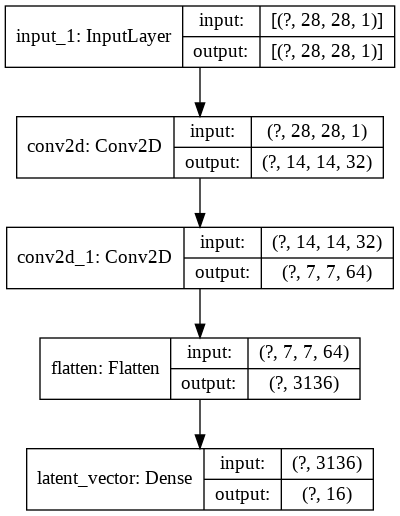

In [12]:
encoder.summary()
plot_model(encoder, to_file ='encoder.png', show_shapes = True)

In [13]:
#build the decoder model
latent_inputs = Input(shape = (latent_dim,), name = 'decoder_input')

#latent to flatten layer (16) -> (7*7*64)
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
#from flatten to suitable volume
x = Reshape((shape[1], shape[2], shape[3]))(x)

#stack of conv2dtranspose(64) and 32
for filters in layer_filters[::-1] :
  x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      activation = 'relu',
                      strides = 2,
                      padding = 'same')(x)

#reconstruct input
outputs = Conv2DTranspose(filters = 1,
                          kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same',
                          name = 'decoder_output')(x)

#instantiate decoder model
decoder = Model(latent_inputs, outputs, name = 'decoder')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

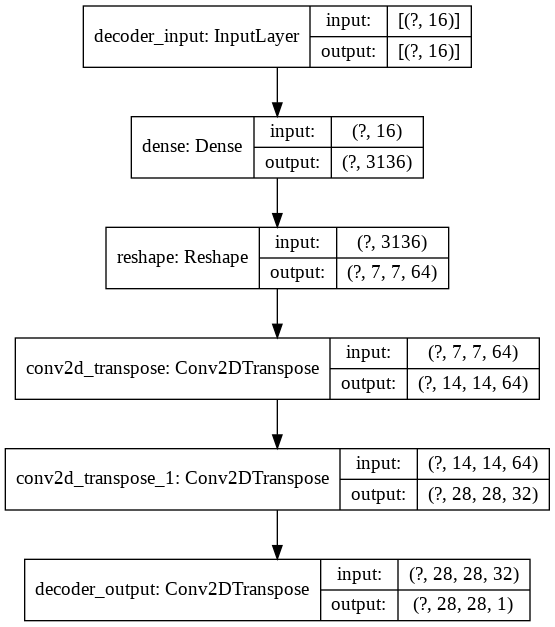

In [14]:
decoder.summary()
plot_model(decoder, to_file = 'dcoder.png', show_shapes = True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


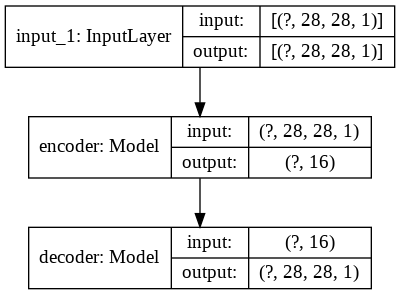

In [15]:
#auto encoder model
autoencoder = Model(inputs, 
                    decoder(encoder(inputs)),
                    name = 'autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes = True)

In [16]:
autoencoder.compile(loss = 'mse', optimizer = 'adam') #no accuracy since unsupervised

In [17]:
#target is same as input
autoencoder.fit(X_train_noisy, X_train, validation_data=(X_test_noisy, X_test), epochs =10, batch_size = batch_size)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0360 - val_loss: 0.0199
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0190 - val_loss: 0.0177
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0175 - val_loss: 0.0169
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0167 - val_loss: 0.0165
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

In [18]:
X_decoded = autoencoder.predict(X_test_noisy)

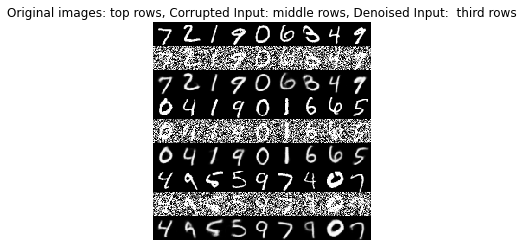

In [19]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([X_test[:num], X_test_noisy[:num], X_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, img_size, img_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, img_size, img_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '          
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()